In [8]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации
 
from sklearn import metrics # метрики
from sklearn import model_selection # методы разделения и валидации
from sklearn import linear_model # линейные модели
from sklearn import tree # деревья решений

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

### Задание 3.3
Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам:

In [9]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, # количество объектов
    n_features=2, # количество признаков
    n_informative=2, # количество информативных признаков
    n_redundant=0, # количество неинформативных признаков
    n_classes=2, # количество классов
    weights=[1, 0.2], # пропорции классов
    random_state=40 # генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

### Проверка сбалансированности классов

In [10]:
y.value_counts(normalize=True) * 100

0    90.0
1    10.0
Name: proportion, dtype: float64

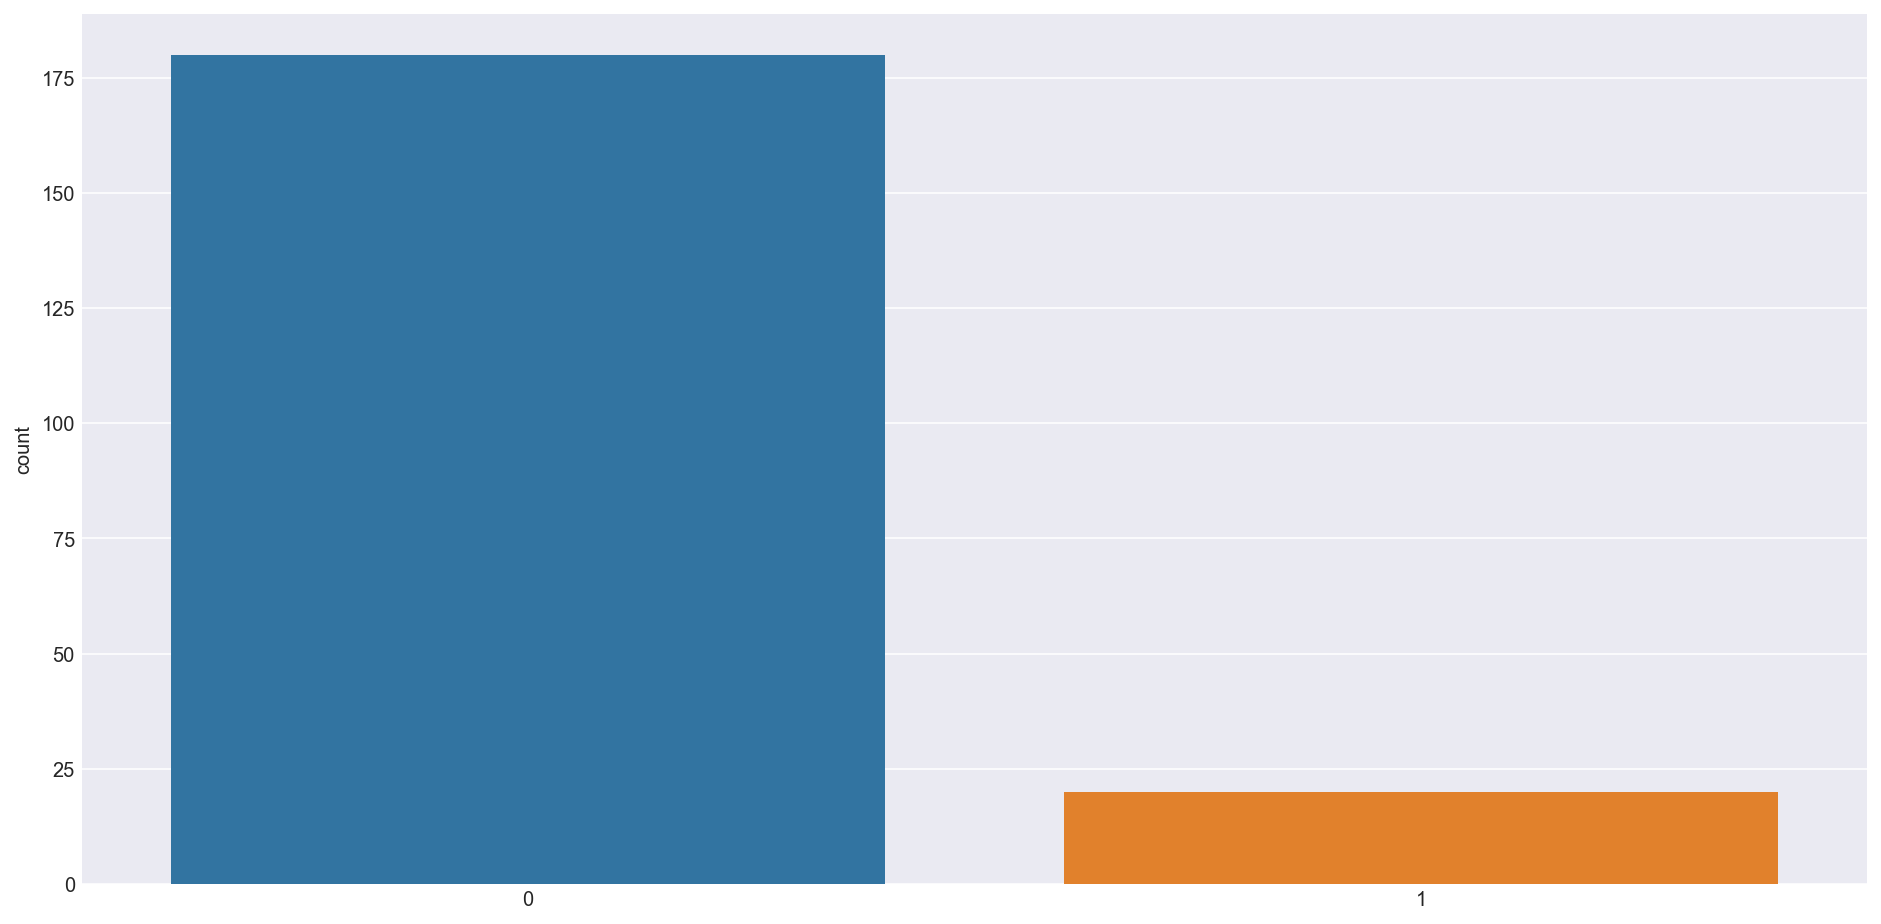

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(x=y)
plt.show()

Классы максимально несбалансированны

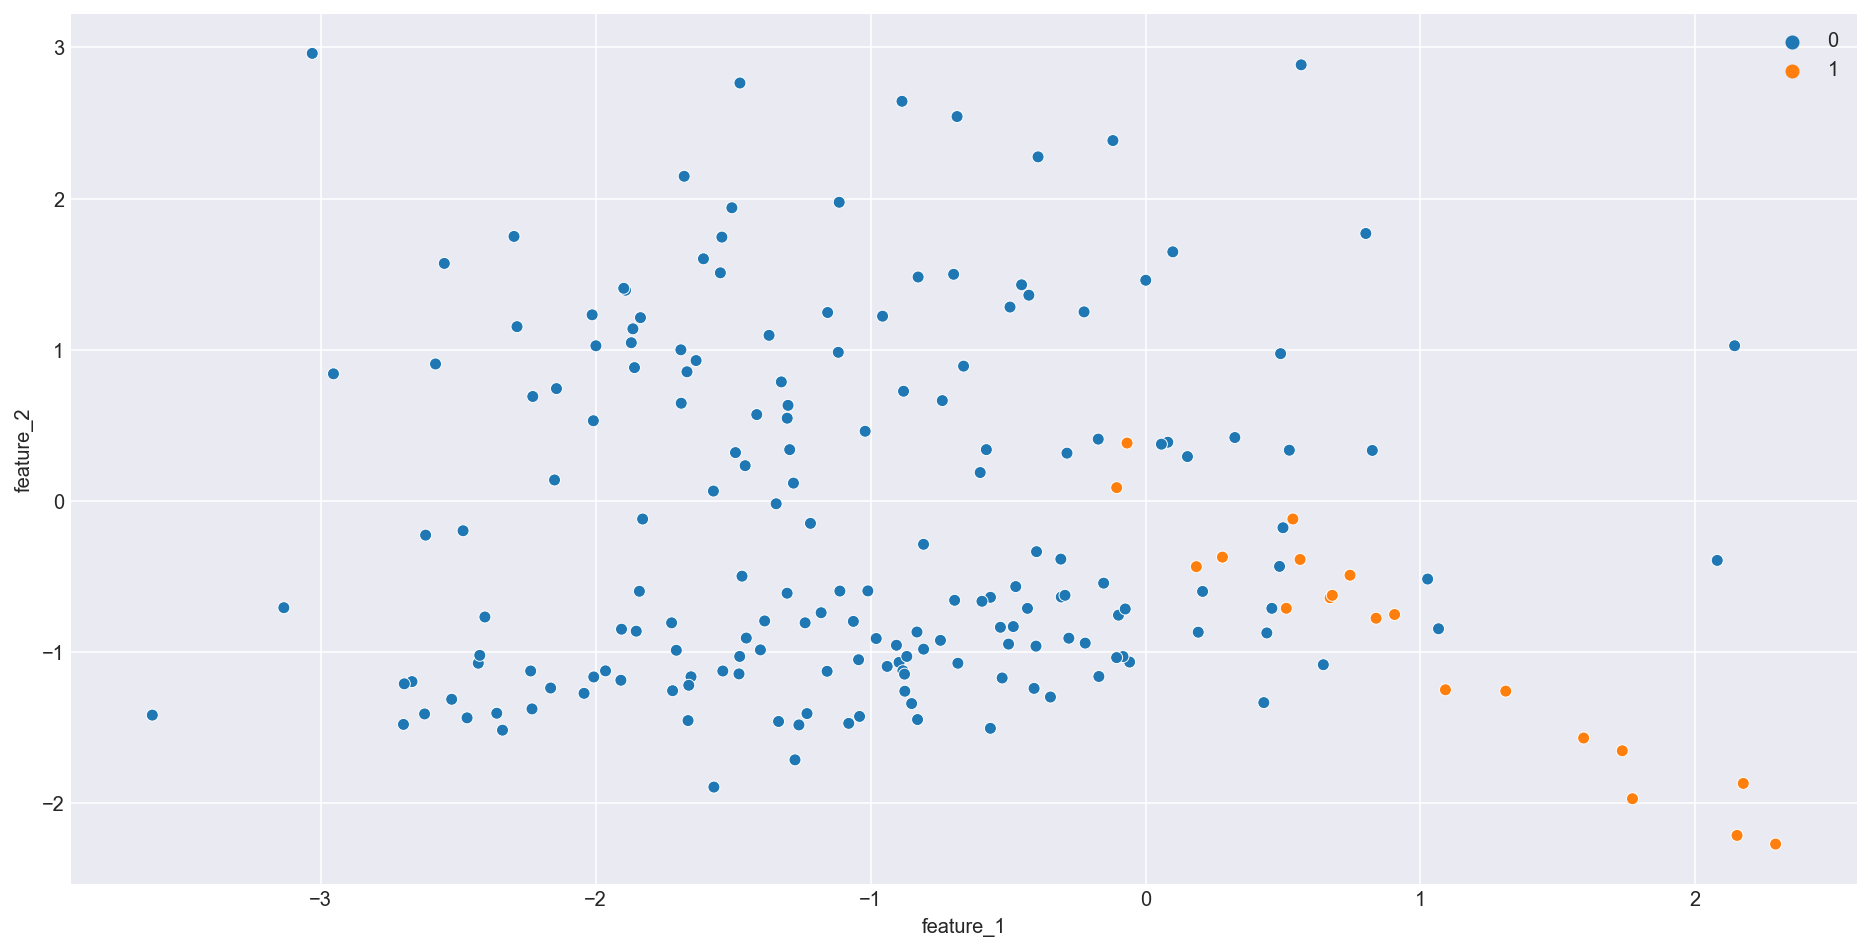

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y)
plt.show()

Разбейте исходный набор данных на тренировочный и валидационный со стратификацией по классам в соотношении 80/20. В качестве значения параметра random_state возьмите число 42.

Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.

In [13]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

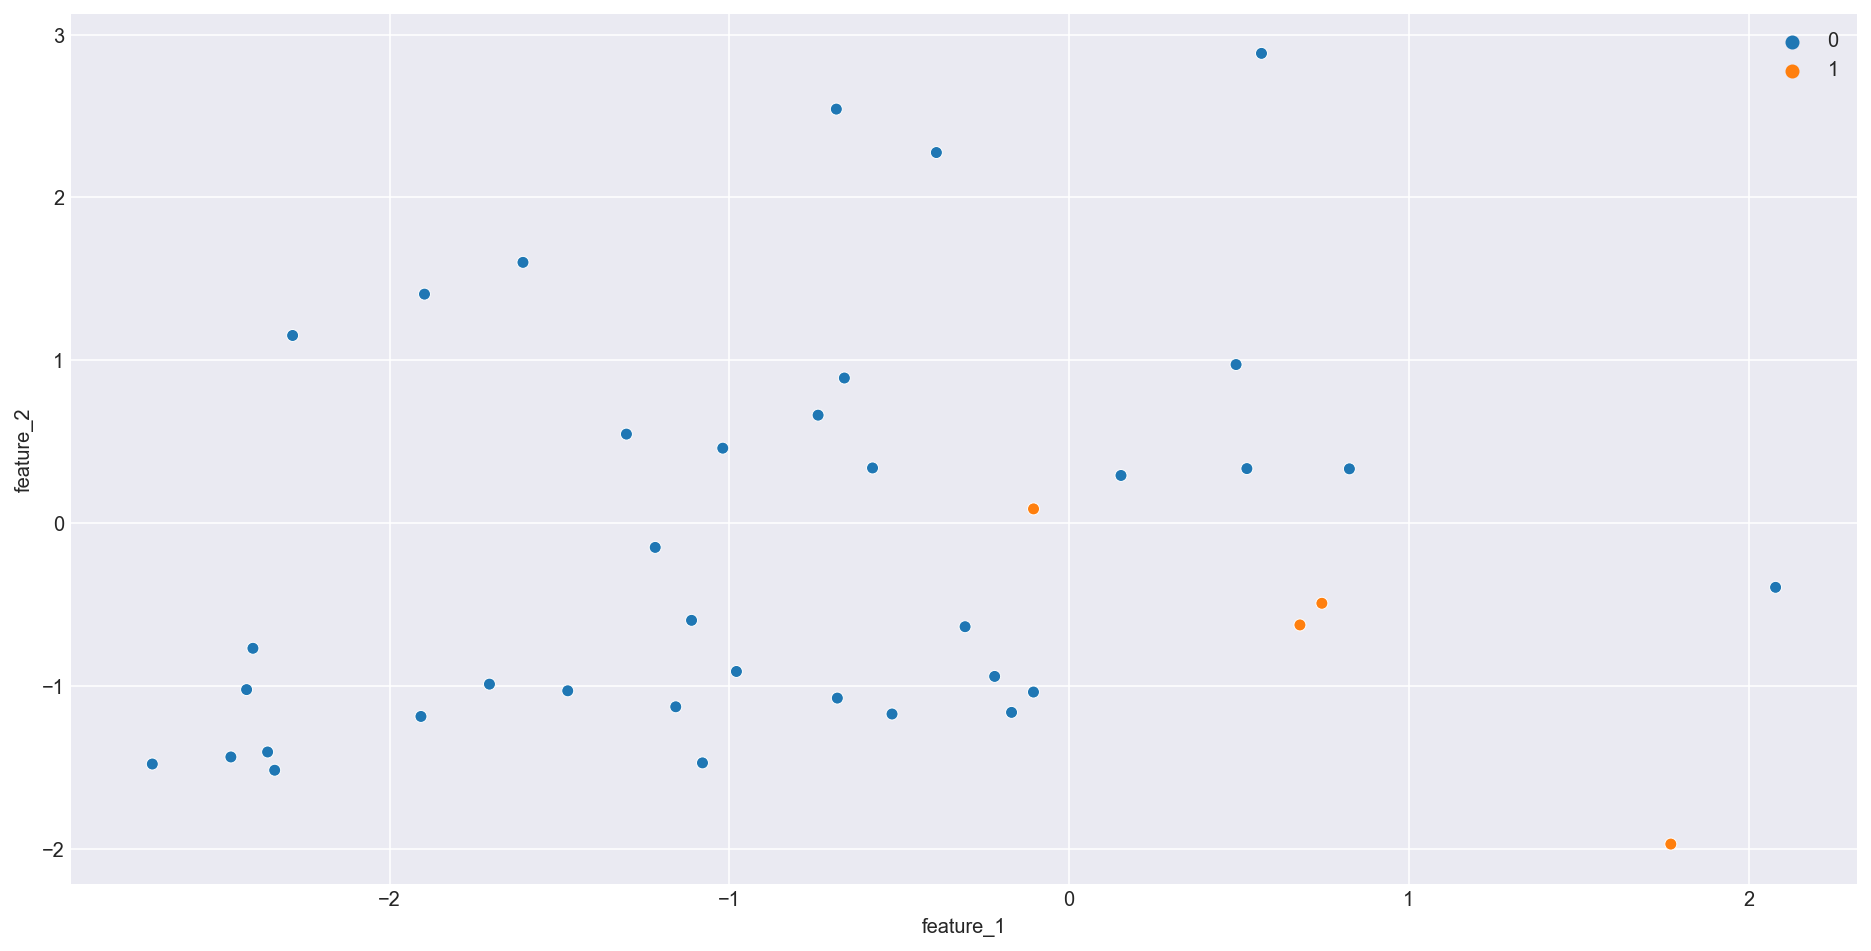

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y_valid)
plt.show()

### Задание 3.5
Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

Обучите модель логистической регрессии на тренировочной выборке (все параметры оставьте по умолчанию).

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [8]:
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train)

# Обучаем модель на тренировочной выборке
lr.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_valid_pred = lr.predict(X_valid)

# Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



### Задание 3.6 (на самопроверку)
Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того, чтобы построить разделяющую поверхность логистической регрессии.

Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.5 логистическую регрессию.

In [9]:
# Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    # Генерируем координатную сетку из всех возможных значений для признаков
    # Glucose изменяется от x1_min = 44 до x2_max = 199, 
    # BMI - от x2_min = 18.2 до x2_max = 67.1
    # Результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    
    # Вытягиваем каждый из массивов в вектор-столбец - reshape(-1, 1)
    # Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    
    # Предсказывает вероятность для всех точек на координатной сетке
    # Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    
    # Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    
    # Создаем фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (16, 8))
    
    # Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    
    # Рисуем разделяющую плоскость - линия, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    
    # Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    
    # Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    
    # Даем графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    
    # Смещаем легену в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\avvoy\AppData\Local\Temp\ipykernel_17628\979104710.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


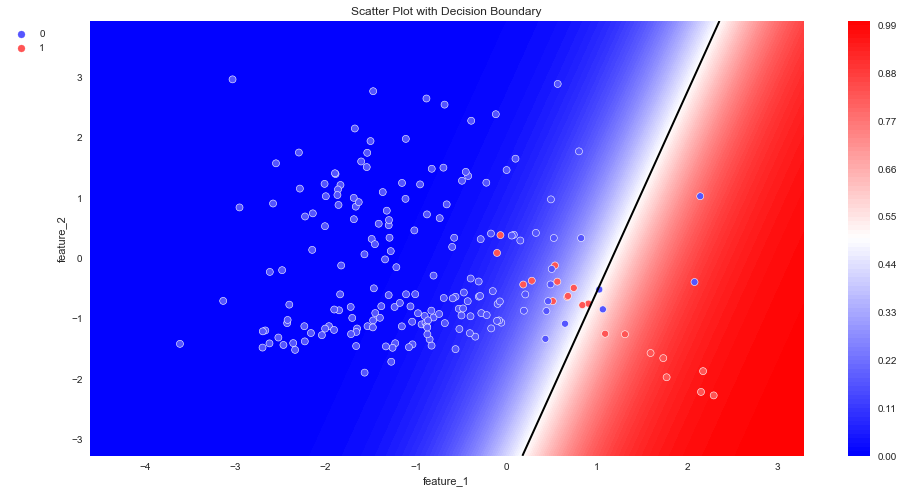

In [10]:
plot_probabilities_2d(X, y, lr)

### ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Большинство моделей, реализованных в sklearn, имеют параметр class_weight — веса классов.

Для того чтобы задать веса классам по приведённым выше формулам, 

достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

In [11]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42, # генератор случайных чисел
    class_weight='balanced' # веса классов
)

# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



### Задание 3.7
Обучите модель логистической регрессии на тренировочной выборке, уставив сбалансированные веса для классов.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [12]:
lr = linear_model.LogisticRegression(class_weight='balanced')

# Обучаем модель на тренировочной выборке
lr.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_valid_pred = lr.predict(X_valid)

# Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



Балансировка для модели логистической регрессии так же улучшает метрики для миноритарного класса, но за счет мажоритарного

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\avvoy\AppData\Local\Temp\ipykernel_17628\979104710.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


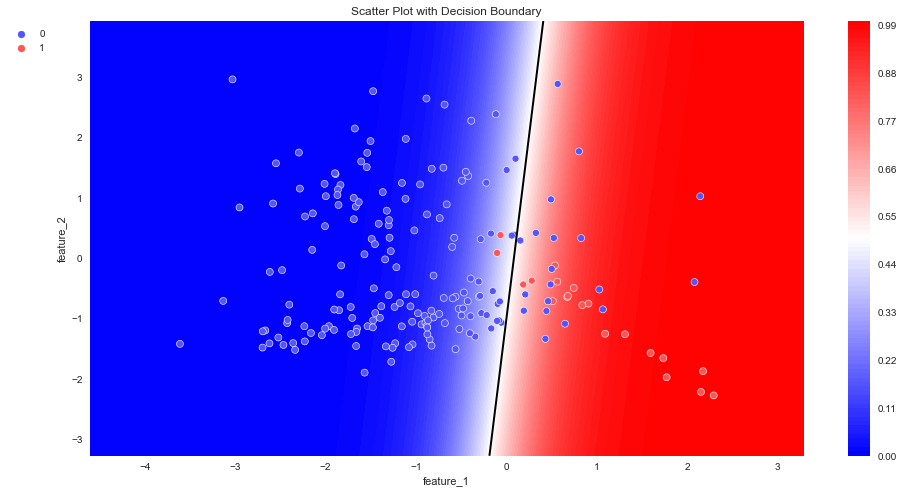

In [13]:
plot_probabilities_2d(X, y, lr)

F1 для класса 0 упала, но при этом выросла для класса 1.

На разделяющей поверхности видно, что мы теперь меньше упускаем обеъкты класса 1.

### Задание 3.11
Сбалансируйте тренировочную выборку с помощью алгоритма SMOTE. В качестве значения параметра random_state возьмите число 42, остальные параметры оставьте по умолчанию.

Обучите модель логистической регрессии на пересэмплированной тренировочной выборке. Все параметры оставьте по умолчанию.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [14]:
from imblearn.over_sampling import SMOTE

In [15]:
sm = SMOTE(random_state=42)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

In [16]:
print(X_train.shape)
print(X_train_s.shape)

(160, 2)
(288, 2)


In [17]:
print(y_train.value_counts())
print(y_train_s.value_counts())

0    144
1     16
dtype: int64
1    144
0    144
dtype: int64


In [18]:
lr = linear_model.LogisticRegression()

# Обучаем модель на тренировочной выборке
lr.fit(X_train_s, y_train_s)

# Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train_s)
y_valid_pred = lr.predict(X_valid)

# Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\avvoy\AppData\Local\Temp\ipykernel_17628\979104710.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


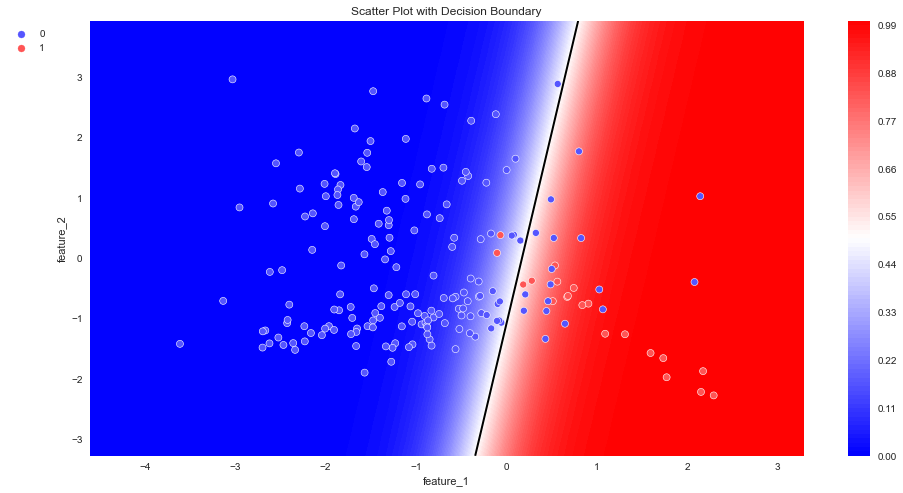

In [19]:
plot_probabilities_2d(X, y, lr)

Заметьте, что качество всех рассмотренных методов приблизительно одинаковое — они дают примерно идентичное значение метрик. Так получилось для конкретного примера набора данных. Для другого набора данных может получиться совершенно иной результат. Какой из методов сработает лучше, заранее сказать нельзя.

### Задание 4.3
Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам.

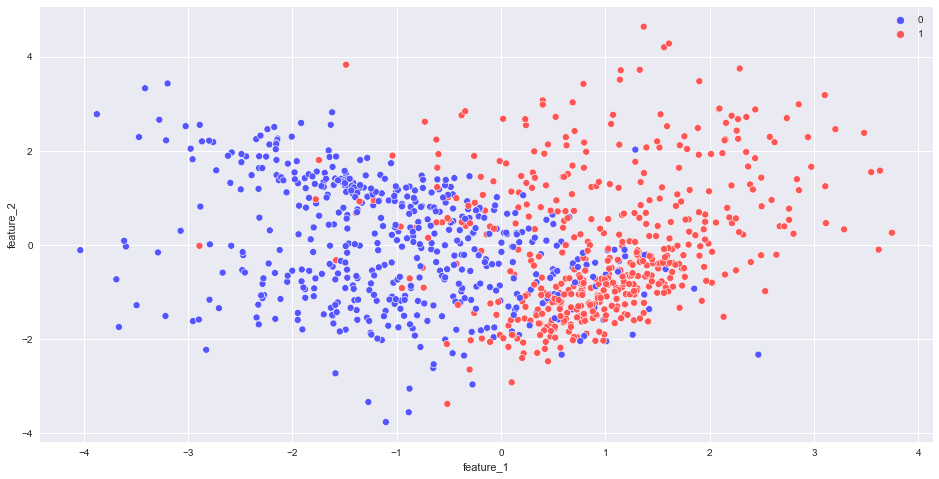

In [20]:
from sklearn import datasets

X, y = datasets.make_classification(
    n_samples=1000, # количество объектов
    n_features=2, # количество признаков
    n_informative=2, # количество информативных признаков
    n_redundant=0, # количество неинформативных признаков
    n_classes=2, # количество классов
    n_clusters_per_class=2, # количество кластеров внутри класса
    random_state=1 # генератор случайных чисел
)

X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

fig, ax = plt.subplots(figsize = (16, 8))
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic', ax=ax)
plt.show()

In [21]:
y.value_counts(normalize=True) * 100

1    50.1
0    49.9
dtype: float64

Выборка сбалансирована

Разделите исходный набор данных на тренировочную и валидационную выборки в соотношении 70/30, используя функцию train_test_split(). В качестве значения параметра random_state возьмите число 42.

In [22]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

Обучите модель дерева решений с глубиной 10 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке. 

Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.

In [23]:
model = tree.DecisionTreeClassifier(
    max_depth=10
)

# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значения метрик
print(f'Train accuracy: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'Valid accuracy: {metrics.accuracy_score(y_valid, y_valid_pred):.2f}')

Train accuracy: 0.98
Valid accuracy: 0.82


c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\avvoy\AppData\Local\Temp\ipykernel_17628\979104710.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


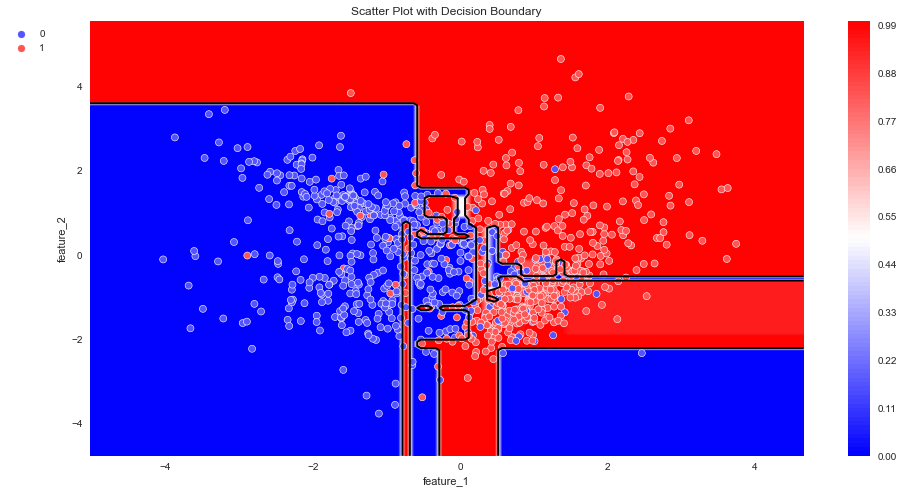

In [24]:
plot_probabilities_2d(X, y, model)

### Задание 4.6
Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 4.3

Обучите модель дерева решений с глубиной 3 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке.

Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.

In [25]:
model = tree.DecisionTreeClassifier(
    max_depth=3
)

# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значения метрик
print(f'Train accuracy: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'Valid accuracy: {metrics.accuracy_score(y_valid, y_valid_pred):.2f}')

Train accuracy: 0.88
Valid accuracy: 0.85


c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\avvoy\AppData\Local\Temp\ipykernel_17628\979104710.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


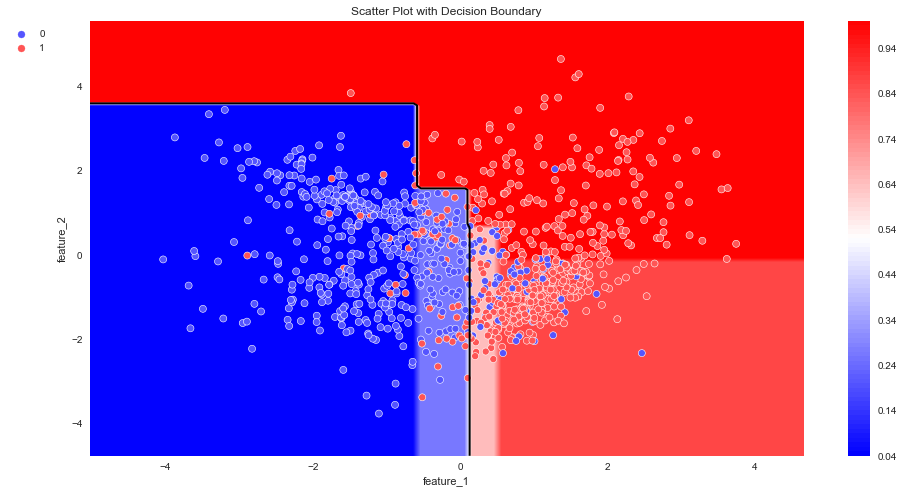

In [26]:
plot_probabilities_2d(X, y, model)